<center>
    <hr width='75%' style='height:1px'>
    <h3><b>Getting Insights into Quantum-Chemical Relations</b></h3>
    <hr width=75% style='height:1px'>
</center>
<br>

#### Goal:

To extract quantum-chemical insights from the '[QM7 dataset](http://quantum-machine.org/data/qm7.mat)' of molecules.

#### 1. The QM7 dataset

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import io
from scipy.spatial.distance import cdist, euclidean
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import itertools
import mplcursors
from collections import Counter

In [2]:
data = io.loadmat('data/qm7.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])

The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms. The 3d
coordinates of each atom in each molecule are available in the variable R. It is an array of size 7165×23×3
containing for each molecule and atom a triplet representing the 3d coordinates. The variable Z is an array
of size 7165×23 which gives for each molecule and atom of the molecule the corresponding atomic number.
An atomic number of 1 corresponds to a hydrogen atom (H), the number 6 corresponds to carbon (C), the
numbers 7 and 8 to nitrogen (N) and oxygen (O) respectively, and finally, the number 16 corresponds to
sulfur (S). If the number is zero, then it indicates that there is no atom at this index, and the corresponding
3d coordinate is ignored

In [3]:
coords = np.array(data['R']) # shape (7165, 23, 3)
atomic_nums = np.array(data['Z']) # shape (7165, 23)
atomization_energies = np.array(data['T']) # shape (1, 7165)

In [4]:
coords.shape, atomic_nums.shape, atomization_energies.shape

((7165, 23, 3), (7165, 23), (1, 7165))

##### 1.1 Visualizing molecules

The following function visualizes the molecules (at random) in the data using both a 2D scatter plot and a 3D one.

The number of molecules to be visualized can be set using the `n_molecules` parameter whose default value is 5.

Specific moelcules can also be plotted by passing a list of indices to the `indices` parameter.

The `THRESHOLD` parameter is used to plot the bonds between atoms and is set to 3.0 by default.

To make the 3D plot interactive, the `iteractive` parameter is set to `True`.

In [5]:
# Setting different colors for different atoms
COLOR_MAPPING = {
    1: [1, 0, 0],  # Hydrogen = red
    6: [0, 1, 0],  # Carbon   = green
    7: [1, 0, 1],  # Nitrogen = purple
    8: [0, 0, 1],  # Oxygen   = blue
    16: [1, 1, 0]  # Sulfur   = yellow
}

def plot_molecules(coords, atomic_nums, n_molecules=5, molecule=-1, THRESHOLD=3.0, interactive=False):
    if interactive:
        %matplotlib notebook
    else:
        %matplotlib inline

    print('H: 🔴,  C: 🟢, N: 🟣, O: 🔵, S: 🟡')
    
    # if molecule are given explicitly
    if molecule != -1:
        indices = molecule
        if isinstance(molecule, int):
            indices = [molecule]
        n_molecules = len(indices)    
    else:
        # Generate random indices for selecting molecule
        indices = np.random.choice(range(len(coords)), size=n_molecules, replace=False)
 
    if interactive:
        n_molecules = 1
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        ax2 = [ax] 
    else:
        # Create subplots for each molecule
        fig, axes = plt.subplots(2, n_molecules, figsize=(4*n_molecules, 5), subplot_kw={'projection': '3d'}, 
                                 gridspec_kw={ 'height_ratios': [1, 1.5], 'hspace': 0.5})
    
        if n_molecules == 1:
            ax1 = [axes[1]]
            ax2 = [axes[0]]
        else:
            ax1 = axes[0]
            ax2 = axes[1]
            
        # Loop over the molecules for the 2d-plot
        for i, ax in enumerate(ax1):
            # Remove the existing axis
            ax.remove()
            # Create a new axis with 2D projection
            ax = fig.add_subplot(2, n_molecules, i+1, aspect='equal')
            # Get the molecule data for the current index
            molecule_index = indices[i]
            ith_molecule = coords[molecule_index][atomic_nums[molecule_index] != 0]
            ith_molecule_config = [int(item) for item in atomic_nums[molecule_index][atomic_nums[molecule_index] != 0]]
            ith_molecule_colors = [COLOR_MAPPING[atom] for atom in ith_molecule_config]
            # Plotting atoms
            ax.scatter(ith_molecule[:, 0], ith_molecule[:, 1], c=ith_molecule_colors)
            # Plotting bonds
            for atom1 in ith_molecule:
                for atom2 in ith_molecule:
                    if np.linalg.norm(atom1 - atom2) < THRESHOLD:
                        ax.plot((atom1[0], atom2[0]), (atom1[1], atom2[1]), color='black', linewidth=0.8, alpha=0.6)
            ax.set_title(f'Molecule {molecule_index}')
            # Add padding inside the 2D scatter plot
            x_min, x_max = ax.get_xlim()
            y_min, y_max = ax.get_ylim()
            x_padding = 0.1 * (x_max - x_min)
            y_padding = 0.1 * (y_max - y_min)
            ax.set_xlim(x_min - x_padding, x_max + x_padding)
            ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # Loop over the molecules for the 3d-plot
    for i, ax in enumerate(ax2):
        # Get the molecule data for the current index
        molecule_index = indices[i]
        ith_molecule = coords[molecule_index][atomic_nums[molecule_index] != 0]
        ith_molecule_config = [int(item) for item in atomic_nums[molecule_index][atomic_nums[molecule_index] != 0]]
        ith_molecule_colors = [COLOR_MAPPING[atom] for atom in ith_molecule_config]
        # Plotting atoms
        ax.scatter(ith_molecule[:, 0], ith_molecule[:, 1], ith_molecule[:, 2], c=ith_molecule_colors)
        # Plotting bonds
        for atom1 in ith_molecule:
            for atom2 in ith_molecule:
                if np.linalg.norm(atom1 - atom2) < THRESHOLD:
                    ax.plot((atom1[0], atom2[0]), (atom1[1], atom2[1]), (atom1[2], atom2[2]), color='black', 
                            linewidth=0.8, alpha=0.6)
                    # code to plot bond length
                    # if interactive and np.linalg.norm(atom1 - atom2) != 0:
                        # midpoint = (atom1 + atom2) / 2  # Compute midpoint between atoms
                        # ax.text(midpoint[0], midpoint[1], midpoint[2], f'{np.linalg.norm(atom1 - atom2):.2f}', 
                        # color='red', ha='center', va='center', fontsize=10)
        ax.set_title(f'Molecule {molecule_index}')   
    plt.tight_layout()
    plt.show()

H: 🔴,  C: 🟢, N: 🟣, O: 🔵, S: 🟡


C:\Users\Aditiya\AppData\Local\Temp\ipykernel_13868\963239370.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


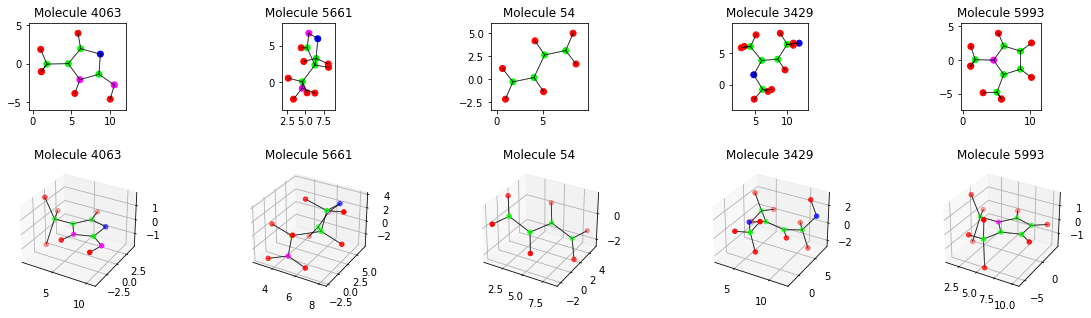

In [6]:
plot_molecules(coords, atomic_nums, n_molecules=5, THRESHOLD=3.0)

H: 🔴,  C: 🟢, N: 🟣, O: 🔵, S: 🟡


<IPython.core.display.Javascript object>


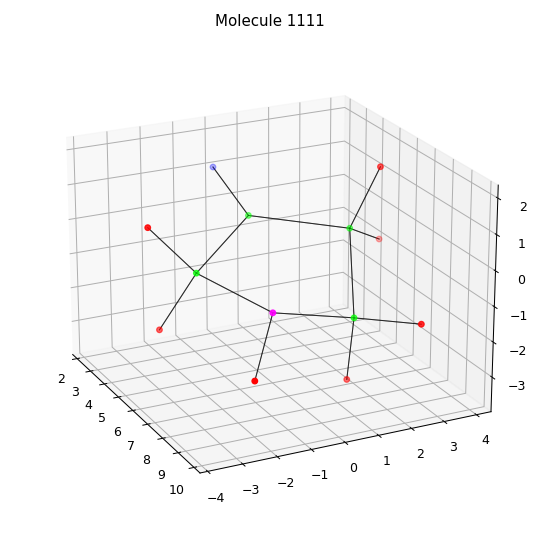

In [7]:
plot_molecules(coords, atomic_nums, molecule=1111, THRESHOLD=3.0, interactive=True)

#### 2. Data Representation, ML model and Explanations

##### 2.1 Data Representation

Let $M = (\epsilon_1, . . . , \epsilon_{|M|})$ be a molecule viewed as a collection of $|M|$ elements i.e. the collection of atoms froming the molecule.

Let $\phi$ be a fuction that maps each element into a vector space $\phi(\epsilon_i) \in \mathbb{R}^h$.

The overall representation can be then built as:

$$ 
\begin{equation}
x = \sum_{i=1}^{|M|} \phi(\epsilon_i) 
\end{equation}
$$

Such a representation is used for Section 3.1 (atom based) and for Section 3.2 (pair based).

A notable property of such representation is that it is invariant to the order of the atoms in the molecule.

##### 2.2 Ridge Regression model

Consider the simple linear regression model:

$$ f(x) = w^\intercal x $$

where the weight vector $w \in \mathbb{R}^h$ is the parameter vector that needs to be learned.

Learning this vector using Ridge Regression consists of minimizing the following objective function:

$$ J(w) = \mathbb{E}[{w^\intercal x - t}^2 + \lambda {\|w\|}^2] $$

where $\mathbb{E}$ is the expectation over all molecules of the training set, $x$ is our input vector and $t$ is the target value.

After centering both the data and the target values, minimizing this objeective yeilds the following closed form solution:

$$ w = {(\Sigma_{xx} + \lambda I)}^{-1} \Sigma_{xt} $$

where $\Sigma_{xx} = \mathbb{E}[x x^\intercal]$ and $\Sigma_{xt} = \mathbb{E}[x t]$ are the auto and cross-covariance matrices respectively.

The performance of this model depends on the choice of the feature map $\phi$ and the regularization parameteter $\lambda$.

For optimizing $\lambda$, we make use of nested cross-validation.

The code for the Ridge Regression framework and for cross-validation is as below.

In [8]:
class RidgeRegression():
    def fit(self, X, t, lambd):
        N, d = X.shape # Data must be of this shape :/
        C_xx = (1/N) * np.dot(X.T, X)
        C_xx_lambda = C_xx + (lambd * np.identity(d))
        C_xt = (1/N) * np.dot(X.T, t)
        self.weights = np.dot(np.linalg.inv(C_xx_lambda), C_xt)
        
    def predict(self, X):
        return np.dot(X, self.weights)
    
    def get_weights(self):
        return self.weights
    
    def get_pred_error(self, t, preds):
        return mean_absolute_error(t, preds)   

The nested cross-validation is achieved using the following helper functions:

- `get_selection_matrix(X, n_folds)` for selecting the data according to the current fold/split

- `cross_validate(X, t, lambda, model, n_folds)` for performing cross-validation against a given value of $\lambda$ for the particular model

- `select_optimal(X, t, lambdas, ridge_model, n_folds)` to select the value of $\lambda$, from a logarithmically spaced pool of values, for which the mean absolute error is the lowest

Finally, the function `nested_cv()` combines the process of hyperparameter selection and evaluation.

In [9]:
def get_selection_matrix(X, n_folds=10):
    n = X.shape[0] // n_folds
    selection_matrix = np.zeros((X.shape[0], n_folds))
    for i in range(n_folds):
        selection_matrix[i*n:(i+1)*n, i] = 1
    return selection_matrix

In [10]:
def cross_validate(X, t, lambd, model, n_folds=10):
    # n_folds = X.shape[0] ideal, but requires too much time to compute
    # I = np.eye(n_folds)
    
    # Split the data into n_folds
    I = get_selection_matrix(X, n_folds)
    
    # Iterate over each fold and train a model on the remaining `n_folds - 1` folds
    errors = []
    for k in range(n_folds):
        X_selection = X[I[:, k] == 0, :]
        t_selection = t[I[:, k] == 0, :]
        X_test = X[I[:, k] == 1, :]
        t_test = t[I[:, k] == 1, :]
        
        model.fit(X_selection, t_selection, lambd) 
        preds = model.predict(X_test)
        error = model.get_pred_error(t_test, preds)
        errors.append(error)
        
    return np.mean(errors), np.std(errors)

In [11]:
def select_optimal(X, t, lambdas, ridge_model, n_folds=10):
    errors = []
    for lambd in lambdas:
        ridge_model = RidgeRegression()
        pred_error, _ = cross_validate(X, t, lambd, ridge_model, n_folds)
        errors.append(pred_error)
        
    idx = np.argmin(errors)
    return lambdas[idx], errors[idx]

In [12]:
def nested_cv(X, t, lambdas, ridge_model, n_folds=10):
    I = get_selection_matrix(X, n_folds)
    errors = []
    vals = []
    
    for k in range(n_folds):
        X_selection = X[I[:, k] == 0, :]
        t_selection = t[I[:, k] == 0, :]
        X_test = X[I[:, k] == 1, :]
        t_test = t[I[:, k] == 1, :]
        
        # get the best lamda for our split
        lamda, _ = select_optimal(X_selection, t_selection, lambdas, ridge_model, n_folds)
        vals.append(lamda)
        
        ridge_model.fit(X_selection, t_selection, lamda)
        preds = ridge_model.predict(X_test)
        error = ridge_model.get_pred_error(t_test, preds)
        errors.append(error)
        
    idx = np.argmin(errors)
    opt_lambda = vals[idx]
    
    mean_err = np.mean(errors)
    std_err = np.std(errors)
    
    return opt_lambda, mean_err, std_err    

##### 2.3 Deeper Insights with Explanations

To get an idea about *what* in the molecule has contributed to the energy prediction, we decompose the prediction into its components using the structure of our model:


$$ f(x) = w^\intercal x $$
$$ f(x) = w^\intercal \left(\sum_{i=1}^{|M|} \phi(\epsilon_i)\right) $$
$$ 
\begin{equation}
f(x) = \sum_{i=1}^{|M|} \underbrace{w^\intercal \phi(\epsilon_i)}_{R_i} \tag{2}
\end{equation}
$$

where the term $R_i$ is the contribution of the $i$-th element to the prediction.

The explanations for the predictions resulting from different representations are listed under Section 3.1.3 and Section 3.2.3 respectively.

#### 3. Experiments

##### 3.1 Simple atom-based Representation

###### 3.1.1 Feature Map

Each molecule $M$ is decomposed into its set of atoms. Then for each atom $\epsilon_i$ we compute a feature vector $\phi(\epsilon_i)$ using one-hot encoding as follows:

$$ \phi(\epsilon_i) = 
\begin{pmatrix} 
I(\epsilon_i = \textrm{H}) \\ 
I(\epsilon_i = \textrm{C}) \\
I(\epsilon_i = \textrm{N}) \\
I(\epsilon_i = \textrm{O}) \\
I(\epsilon_i = \textrm{S}) \\
\end{pmatrix}
\in \mathbb{R}^5 $$

For example, a carbon atom is represented by the vector (0, 1, 0, 0, 0), and a sulfur atom is represented by
the vector (0, 0, 0, 0, 1). This atom representation is now used to generate a feature vector for the molecule $\textrm{CH}_4$ (methane) as $x = (4, 1, 0, 0, 0)$

In [13]:
# one-hot encode the molecules
one_hot_dict = {0: -1, 1: 0, 6: 1, 7: 2, 8: 3, 16: 4}
n = len(one_hot_dict)

# Initialize an empty array to store the one-hot encodings
one_hot_encodings = np.zeros((len(atomic_nums), atomic_nums.shape[1], n-1))

# Iterate over each molecule
for i, molecule_atom_types in enumerate(atomic_nums):
    # Iterate over each atom in the molecule
    for j, atom_type in enumerate(molecule_atom_types):
        # Get the unique index for the atom type
        atom_type_index = one_hot_dict[atom_type]
        # Set the corresponding index in the one-hot encoding to 1
        if atom_type_index != -1:
            one_hot_encodings[i, j, atom_type_index] = 1 
# Each molecule has a one-hot encoding for each atom, representing the atom type        

#  build an overall feature representation by summing the representation of each element
X = np.sum(one_hot_encodings, axis=1)
print(f'X-shape(N x d): {X.shape}') # N x d

X-shape(N x d): (7165, 5)


###### 3.1.2 Hyperparameter Optimization, Cross-Validation, and Predictions

The above obtained representation is used to train the Ridge Regression model after selecting the optimal value of $\lambda$ using a 5-fold nested cross-validation and a mean absolute error of approximately 15 kcal/mol is obtained 

In [14]:
# Centering
X_centered = X - np.mean(X, axis=0, keepdims=True)
T = atomization_energies - np.mean(atomization_energies)
T = T.reshape(-1, 1)

In [15]:
lambdas = np.logspace(-20 , 10, 31)

ridge_model = RidgeRegression()
optimal_lambda, mean_err, std_err = nested_cv(X_centered, T, lambdas, ridge_model, 5)
print(f'Optimal hyperparameter: {optimal_lambda}')
print(f'Error: {mean_err:.2f} +/- {std_err:.2f} kcal/mol')

Optimal hyperparameter: 0.0001
Error: 16.41 +/- 1.24 kcal/mol


Training the model using the optimal value of $\lambda$ and evaluating it on the test set.

In [16]:
X_train, X_test, t_train, t_test = train_test_split(X_centered, T, test_size=0.2)

ridge_model.fit(X_train, t_train, optimal_lambda) # and our model is ready to predict
preds = ridge_model.predict(X_test)
mean_abs_err = ridge_model.get_pred_error(t_test, preds)
print(f'Optimal lambda: {optimal_lambda}')
print(f'Mean absolute error: {mean_abs_err:.2f} kcal/mol')

Optimal lambda: 0.0001
Mean absolute error: 15.24 kcal/mol


###### 3.1.3 Explanations

We decompose $X$ into its elements and compute the contribution of each element to the prediction using equation no. (2)

In [17]:
one_hot_encodings.shape
# each row corresponds to phi(e_i)
# Here, M = 23

(7165, 23, 5)

In [18]:
# decompose X into its elements
X_explained = one_hot_encodings 
weights = ridge_model.get_weights()
explanations = np.dot(X_explained, weights)
predictions = np.dot(X_centered, weights) # same as ridge_model.predict(X_centered)
print(f'Predictions: {predictions.shape} ')
print(f'Explanations: {explanations.shape}')

Predictions: (7165, 1) 
Explanations: (7165, 23, 1)


As seen above, the prediction of each molecule is now decomposed into the contributions of its atoms.

In [19]:
# Helper functions to get the contributions and encodings for a given molecule along with its atom labels

reverse_one_hot_dict = {-1: 0, 0: 1, 1: 6, 2: 7, 3: 8, 4: 16}
atomic_num_to_symbol = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 16: 'S'}

def get_contributions_and_encodings(molecule_idx):
    contributions = explanations[molecule_idx]
    encodings = one_hot_encodings[molecule_idx]

    # remove the zero contributions
    contributions = np.abs(contributions[np.nonzero(contributions)])
    encodings = encodings[np.any(encodings==1, axis=1)]

    return contributions, encodings

def get_atom_labels(encodings):
    atom_labels = [] 
    for encoding in encodings:
        atom_type_index = np.argmax(encoding)
        atom_type = reverse_one_hot_dict[atom_type_index]
        atom_symbol = atomic_num_to_symbol[atom_type]
        atom_labels.append(atom_symbol)
    return atom_labels   

The following cell shows how much each atom of molecule '0' i.e. $\textrm{CH}_4$ has contributed to its prediction, as a bar plot

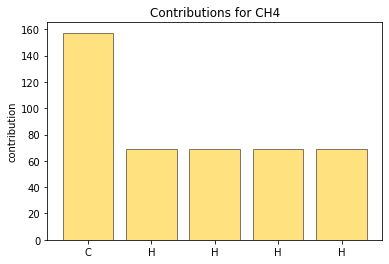

In [20]:
%matplotlib inline

contributions, encodings = get_contributions_and_encodings(0)

n = len(contributions)
x = np.arange(n)

fig, ax = plt.subplots()
ax.bar(x, contributions.flatten(), align='center', color='#FFC600', edgecolor='black', alpha=0.5)

labels = get_atom_labels(encodings)
        
ax.set_xticks(x)
ax.set_xticklabels(labels)  
ax.set_ylabel('contribution')
ax.set_title('Contributions for CH4')

plt.show()

We now visualize the contributions of each molecule interactively as the size of atoms it consists of (bigger atom size corresponds to higher contribution to the molecule's atomization energy)

In [21]:
tsne = TSNE() # use t-SNE to scatter plot the molecules according to their atomization energies
embedded_data = tsne.fit_transform(X_centered)

autumn = plt.cm.get_cmap('autumn').reversed()
gray = plt.cm.get_cmap('gray').reversed()

Click on a point in the t-SNE representation to view its structure on the right (the size of atom indicates its contribution to the Atomization Energy of the molecule)
H: 🔴,  C: 🟢, N: 🟣, O: 🔵, S: 🟡


<IPython.core.display.Javascript object>


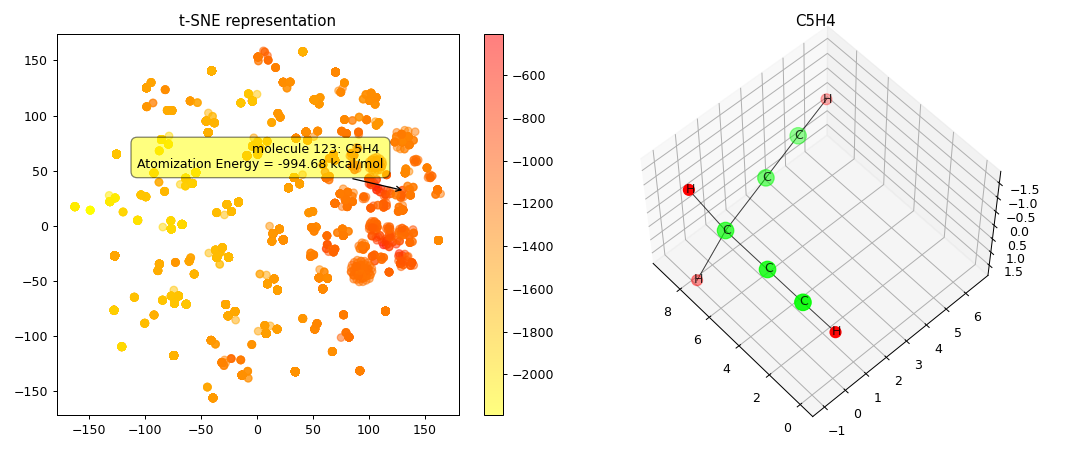

In [22]:
# making it interactive
%matplotlib notebook 

COLOR_MAPPING = {
    1: [1, 0, 0],  # Hydrogen = red
    6: [0, 1, 0],  # Carbon   = green
    7: [1, 0, 1],  # Nitrogen = purple
    8: [0, 0, 1],  # Oxygen   = blue
    16: [1, 1, 0]  # Sulfur   = yellow
}
print('Click on a point in the t-SNE representation to view its structure on the right (the size of atom indicates its contribution to the Atomization Energy of the molecule)')
print('H: 🔴,  C: 🟢, N: 🟣, O: 🔵, S: 🟡')

# Visualize the t-SNE representation with the molecule's structure on the side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
ax1.remove()
ax1 = fig.add_subplot(1, 2, 1)
scatter = ax1.scatter(embedded_data[:, 0], embedded_data[:, 1], c=atomization_energies[0, :], cmap=autumn, alpha=0.5)
ax1.set_title('t-SNE representation')

contributions, encodings = get_contributions_and_encodings(0)
molecule = coords[0][atomic_nums[0] != 0]
molecule_config = [int(item) for item in atomic_nums[0][atomic_nums[0] != 0]]
molecule_colors = [COLOR_MAPPING[atom] for atom in molecule_config]
labels = get_atom_labels(encodings)

ax2 = axes[1]
ax2.remove()
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter_plot = ax2.scatter(molecule[:, 0], molecule[:, 1], molecule[:, 2], c=molecule_colors, s=contributions*1.1)
ax2.set_title(f'CH4')
for i, atom1 in enumerate(molecule):
    for atom2 in molecule:
        if np.linalg.norm(atom1 - atom2) < 3.0:
            ax2.plot((atom1[0], atom2[0]), (atom1[1], atom2[1]), (atom1[2], atom2[2]), color='black', linewidth=0.8, alpha=0.6)
    offset = atom1 + 0.16
    ax2.text(offset[0], offset[1], offset[2], f'{labels[i]}', color='black', ha='center', va='center', fontsize=10, alpha=0.8)

# Function to update the molecule's structure based on the clicked point
def update_scatter_plot(cursor):
    index = cursor.target.index
    idx = int(index)
    contributions, encodings = get_contributions_and_encodings(idx)
    molecule = coords[idx][atomic_nums[idx] != 0]
    molecule_config = [int(item) for item in atomic_nums[idx][atomic_nums[idx] != 0]]
    molecule_colors = [COLOR_MAPPING[atom] for atom in molecule_config]

    ax2.clear()
    scatter_plot = ax2.scatter(molecule[:, 0], molecule[:, 1], molecule[:, 2], c=molecule_colors, s=contributions*1.1)
    
    labels = get_atom_labels(encodings)
    
    for i, atom1 in enumerate(molecule):
        for atom2 in molecule:
            if np.linalg.norm(atom1 - atom2) < 3.0:
                ax2.plot((atom1[0], atom2[0]), (atom1[1], atom2[1]), (atom1[2], atom2[2]), color='black', 
                         linewidth=0.7, alpha=0.5)
        offset = atom1 + 0.16
        ax2.text(offset[0], offset[1], offset[2], f'{labels[i]}', color='black', ha='center', va='center', 
                 fontsize=10, alpha=0.8)
    
    element_counts = Counter(labels)
    unique_elements = sorted(set(labels))
    name = ''.join([element + str(element_counts[element]) for element in unique_elements])
    
    ax2.set_title(f'{name}')
    
    txt = f'molecule {idx}: {name} \nAtomization Energy = {(atomization_energies[0, idx]):.2f} kcal/mol'
    ann = cursor.annotation
    ann.set_text(txt)
    plt.draw()

# Connect the cursor event to the update_scatter_plot function
cursor1 = mplcursors.cursor(scatter, hover=False)
cursor1.connect("add", update_scatter_plot)

plt.colorbar(scatter, ax=ax1)
plt.tight_layout()
plt.show()

From above, one can observe that atoms with higher electronegativity(such as C, N, and O) contribute more to the atomization energy of the molecule. 

Also, as carbon atoms are typically stable, their contribution to the molecule's atomization energy is more pronounced. These insights are consistent with the prevailing chemical context. 

##### 3.2 Models with pairs of atoms

Each molecule is now decomposed into its set of pair of atoms, i.e. $\epsilon_i$ now denotes a pair of atoms, and a molecule contains $\frac{\#atoms \cdot (\#atoms - 1)}{2}$ such pairs.


###### 3.2.1 Feature Maps

To generate one-hot encodings for each pair, we bin them into multiple intervals $[\theta_1, \theta_2], [\theta_2, \theta_3], [\theta_{m-1}, \theta_m]$ and get the vector:

$$
\phi^A(\epsilon_i) = 
\begin{pmatrix} 
I(\theta_1 \le dist(\epsilon_i) \lt \theta_2) \\ 
I(\theta_2 \le dist(\epsilon_i) \lt \theta_3) \\
\dots \\
I(\theta_{m-1} \le dist(\epsilon_i) \lt \theta_m) \\
\end{pmatrix}
$$

And to avoid introducing unnatural discontinuities into the model, the hard indicator function $I$ is replaced by a soft indicator function i.e. a Gaussian function with mean at the center of the interval and fixed variance.

The size of the intervals and the variance are chosen heuristically.

In [23]:
def get_feature_map_A(distance_pairs, interval, variance=0.08):
    feature_map_A = []

    for row in distance_pairs:
        encoding = []
        for dist in row:
            enc = np.zeros((len(interval) - 1))
            for i in range(len(interval)-1):
                # Hard indicator function
                # if interval[i] <= dist < interval[i+1]:
                    # enc[i] = 1
                # Soft indicator function
                enc[i] = np.exp(-((dist - (interval[i] + interval[i+1])/2)**2) / variance)
            encoding.append(enc)
        feature_map_A.append(encoding)

    return np.array(feature_map_A, dtype=object)




In order to incorporate atom types, another feature representation is generated as follows:

$$
\phi^B(\epsilon_i) = 
\begin{pmatrix} 
I(type(\epsilon_i) = \textrm{HH}) \\ 
I(type(\epsilon_i) = \textrm{HC}) \\
I(type(\epsilon_i) = \textrm{HN}) \\
\dots \\
I(type(\epsilon_i) = \textrm{SS}) \\
\end{pmatrix}
\in \mathbb{R}^{15}
$$

Unordered pairs are considered to implement invariance to indexing.

In [24]:
atoms = ['C', 'H', 'N', 'O', 'S']
combinations = list(itertools.combinations_with_replacement(atoms, 2)) # 15 combinations, unique

def get_feature_map_B(atom_pairs, combinations):    
    feature_map_B = []

    for row in atom_pairs:
        encoding = []
        for pair in row:
            enc = np.zeros((len(combinations)))
            for i in range(len(combinations)):
                if combinations[i][0] == pair[0] and combinations[i][1] == pair[1]:
                    enc[i] = 1
            encoding.append(enc)
        feature_map_B.append(encoding)
    return np.array(feature_map_B, dtype=object)

Finally, the feature maps $\phi_A$ and $\phi_B$ are combined into one single feature map $\phi$ consisting of all products between elements of the two feature maps.

$$ [\phi(\epsilon_i)]_{jk} = \phi_j^A(\epsilon_i) \cdot \phi_k^B(\epsilon_i) \quad \forall j,k$$

The matrix $\phi(\epsilon_i)$ is then flattened into a vector for subsequent processing.

In [25]:
def get_phi(coords, feature_map_A, feature_map_B):   
    phi = []
    phi_explained = []
    for i in range(coords.shape[0]):
        t = []
        for j in range(len(feature_map_A[i])):
            A = np.array(feature_map_A[i][j])
            B = np.array(feature_map_B[i][j])
            temp = np.zeros((len(A), len(B)))
            for l in range(len(A)):
                for m in range(len(B)):
                    temp[l][m] = A[l] * B[m]
            temp = temp.flatten()
            t.append(temp)
        phi_explained.append(np.array(t)) # useful for the explanations part
        phi.append(np.sum(t, axis=0))
        
    return np.array(phi), np.array(phi_explained, dtype=object)

`itertools.combinations_with_replacement` is used to generate all possible pairs of atoms for a molecule and its related distances are also calculated and stored.

In [26]:
# map the atomic numbers to their symbols
molecules = [[atomic_num_to_symbol[x] for x in y if x != 0] for y in atomic_nums]

atom_pairs = []
distance_pairs = []

for i in range(len(molecules)):
    # Generate all combinations of two atoms
    pair = list(itertools.combinations_with_replacement(molecules[i], 2))
    atom_pairs.append(pair)
    # Generate all combinations of atom-atom distances
    distances = coords[i][atomic_nums[i] != 0]
    dist_pair = list(itertools.combinations_with_replacement(distances, 2))
    d = []
    for p in dist_pair:
        d.append(np.linalg.norm(p[0] - p[1]))
    distance_pairs.append(d)
    
atom_pairs = np.array(atom_pairs, dtype=object)
distance_pairs = np.array(distance_pairs, dtype=object)

print(f'Atom pairs\' shape: {atom_pairs.shape}')
print(f'Distance pairs\' shape: {distance_pairs.shape}')

Atom pairs' shape: (7165,)
Distance pairs' shape: (7165,)


One of the below two intervals are chosen for the distance bins along with the value of variance (both set heuristically) and the feature maps are obtained. 

In [27]:
example_interval1 = [0, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1]
example_interval2 = [0, 1.4, 1.6, 1.8, 2.0, 2.4, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0]

feature_map_A = get_feature_map_A(distance_pairs, example_interval2, variance=0.08)
feature_map_B = get_feature_map_B(atom_pairs, combinations)
phi, phi_decomposed = get_phi(coords, feature_map_A, feature_map_B)

print(f'Feature map A shape: {feature_map_A.shape}')
print(f'Feature map B shape: {feature_map_B.shape}')
print(f'Phi shape: {phi.shape}')
# print(f'Phi-decomposed shape: {phi_decomposed.shape}')

Feature map A shape: (7165,)
Feature map B shape: (7165,)
Phi shape: (7165, 210)


The second dimension of the feature maps A and B as well as of the distance-pairs and atom-pairs is different for each molecule as each molecule has different atoms and so different atom-pairs.

###### 3.2.2 Hyperparameter Optimization, Cross-Validation, and Predictions

This new feature map is then used to train the Ridge Regression model after selecting the optimal value of $\lambda$ using a 5-fold nested cross-validation and a mean absolute error of approximately 6 kcal/mol is obtained.

In [29]:
lambdas = np.logspace(-19, 9, 21)

phi_centered = phi - np.mean(phi, axis=0, keepdims=True)
ridger = RidgeRegression()
optimal_lambda, mean_err, std_err = nested_cv(phi_centered, T, lambdas, ridger, 5)

phi_train, phi_test, t_train, t_test = train_test_split(phi_centered, T, test_size=0.2)
ridger.fit(phi_train, t_train, optimal_lambda)
preds = ridger.predict(phi_test)
err = ridger.get_pred_error(t_test, preds)
weights = ridger.get_weights()
print(f'Optimal lambda: {optimal_lambda:.2e}')
print(f'Mean absolute error (phi1): {err:.2f} kcal/mol')

Optimal lambda: 2.51e-11
Mean absolute error (phi1): 4.97 kcal/mol


###### 3.2.3 Explanations

For each molecule, we decompose its prediction into the contributions of its atom-pairs. Such a decomposition is readily avaialable in the matrix `phi_decomposed` that is calulated along with the feature map $\phi$.

In [30]:
print(f'Phi-decomposed shape: {phi_decomposed.shape}')

Phi-decomposed shape: (7165,)


To get the contributions for each atom-pair, each row of `phi_decomposed` is multiplied with the weight vector '$w$' and the explanations are obtained as per equation no. (2)

In [31]:
phi_explained = []
for i in range(len(phi_decomposed)):
    phi_explained.append(np.dot(phi_decomposed[i], weights))
phi_explained = np.array(phi_explained, dtype=object)

We can look at the contributions of each atom-pair of molecule '0' i.e. $\textrm{CH}_4$ as follows:

In [32]:
print(f'Molecule = CH4')
for i in range(len(phi_explained[0])):
    print(f'Pair: {atom_pairs[0][i]} Distance: {float(distance_pairs[0][i]):.1f}Å Contribution: {float(phi_explained[0][i]):.2f}')


Molecule = CH4
Pair: ('C', 'C') Distance: 0.0Å Contribution: -198.53
Pair: ('C', 'H') Distance: 2.1Å Contribution: 19.68
Pair: ('C', 'H') Distance: 2.1Å Contribution: 19.68
Pair: ('C', 'H') Distance: 2.1Å Contribution: 19.67
Pair: ('C', 'H') Distance: 2.1Å Contribution: 19.48
Pair: ('H', 'H') Distance: 0.0Å Contribution: -71.40
Pair: ('H', 'H') Distance: 3.4Å Contribution: -3.26
Pair: ('H', 'H') Distance: 3.4Å Contribution: -3.26
Pair: ('H', 'H') Distance: 3.4Å Contribution: -3.26
Pair: ('H', 'H') Distance: 0.0Å Contribution: -71.40
Pair: ('H', 'H') Distance: 3.4Å Contribution: -3.26
Pair: ('H', 'H') Distance: 3.4Å Contribution: -3.26
Pair: ('H', 'H') Distance: 0.0Å Contribution: -71.40
Pair: ('H', 'H') Distance: 3.4Å Contribution: -3.26
Pair: ('H', 'H') Distance: 0.0Å Contribution: -71.40


To understand the explanations better, we visualize the molecule and show the contibutions as a function of the thickness of the bond. The thicker the bond, the higher the contribution of the corresponding atom-pair to the prediction.

H: 🔴,  C: 🟢, N: 🟣, O: 🔵, S: 🟡
The thickness of the bond shows the contribution of the pair to the atomization energy prediction.


<IPython.core.display.Javascript object>


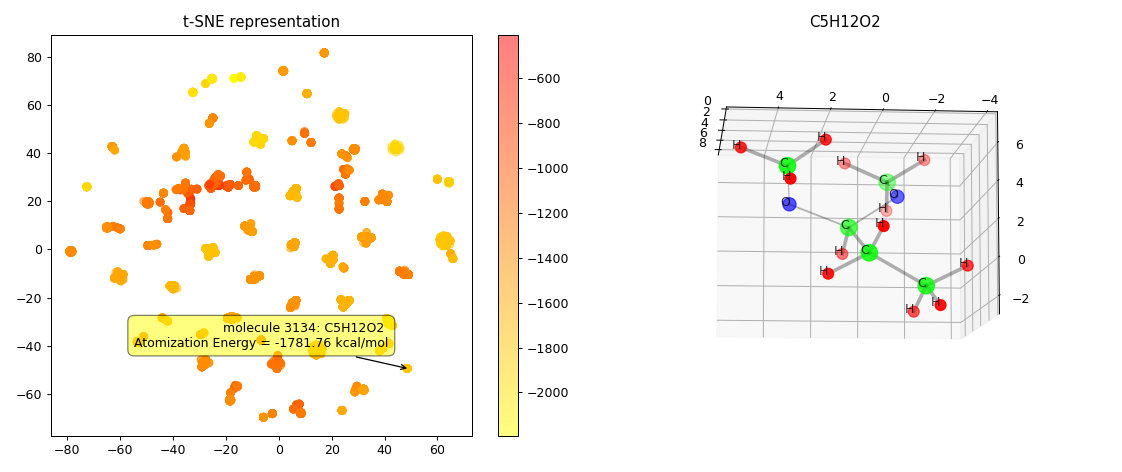

In [33]:
# molecules 66 and 976 are apt

COLOR_MAPPING = {
    1: [1, 0, 0],  # Hydrogen = red
    6: [0, 1, 0],  # Carbon   = green
    7: [1, 0, 1],  # Nitrogen = purple
    8: [0, 0, 1],  # Oxygen   = blue
    16: [1, 1, 0]  # Sulfur   = yellow
}

print('H: 🔴,  C: 🟢, N: 🟣, O: 🔵, S: 🟡')
print('The thickness of the bond shows the contribution of the pair to the atomization energy prediction.')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
ax1.remove()
ax1 = fig.add_subplot(1, 2, 1)
scatter = ax1.scatter(embedded_data[:, 0], embedded_data[:, 1], c=atomization_energies[0, :], cmap=autumn, alpha=0.5)
ax1.set_title('t-SNE representation')

molecule = coords[0][atomic_nums[0] != 0]
molecule_config = [int(item) for item in atomic_nums[0][atomic_nums[0] != 0]]
molecule_colors = [COLOR_MAPPING[atom] for atom in molecule_config]
atoms = atom_pairs[0]
distances = distance_pairs[0]
explanationz = phi_explained[0]
contributions, encodings = get_contributions_and_encodings(0)
labels = get_atom_labels(encodings)
colors = (np.array(explanationz) - np.min(explanationz)) / (np.max(explanationz) - np.min(explanationz))

ax2 = axes[1]
ax2.remove()
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter_plot = ax2.scatter(molecule[:, 0], molecule[:, 1], molecule[:, 2], c=molecule_colors, s=contributions*1.1)
ax2.set_title(f'CH4')

counter = 0
for i, atom1 in enumerate(molecule):
    offset = atom1 + 0.16
    ax2.text(offset[0], offset[1], offset[2], f'{labels[i]}', color='black', alpha=0.8, ha='center', va='center')

    for atom2 in molecule[i:]:
        if counter == len(distances):
            break

        if 0 < distances[counter] <= 3.0:
            ax2.plot((atom1[0], atom2[0]), (atom1[1], atom2[1]), (atom1[2], atom2[2]), c=gray(colors[counter]), 
                     linewidth=abs(explanationz[counter]/10)+1, alpha=0.3)
            # show the contribution value/distance at the center of the bond
            # midpoint = (atom1 + atom2) / 2
            # ax.text(midpoint[0], midpoint[1], midpoint[2], f'{float(explanations[counter]):.2f}', color='red', 
            # ha='center', va='center', fontsize=10)
            # ax.text(midpoint[0], midpoint[1], midpoint[2], f'{distances[counter]:.2f}', color='red', ha='center', 
            # va='center', fontsize=10)
        counter += 1

# Function to update the molecule's strucutre based on the clicked point
def update_scatter_plot(cursor):
    index = cursor.target.index
    idx = int(index)
    contributions, encodings = get_contributions_and_encodings(idx)
    atoms = atom_pairs[idx]
    distances = distance_pairs[idx]
    explanationz = phi_explained[idx]
    molecule = coords[idx][atomic_nums[idx] != 0]
    molecule_config = [int(item) for item in atomic_nums[idx][atomic_nums[idx] != 0]]
    molecule_colors = [COLOR_MAPPING[atom] for atom in molecule_config]
    colors = (np.array(explanationz) - np.min(explanationz)) / (np.max(explanationz) - np.min(explanationz))
    labels = get_atom_labels(encodings)

    ax2.clear()
    scatter_plot = ax2.scatter(molecule[:, 0], molecule[:, 1], molecule[:, 2], c=molecule_colors, s=contributions*1.1)
    
    counter = 0
    for i, atom1 in enumerate(molecule):
        offset = atom1 + 0.16
        ax2.text(offset[0], offset[1], offset[2], f'{labels[i]}', color='black', alpha=0.8, ha='center', va='center')
        
        for atom2 in molecule[i:]:
            if counter == len(distances):
                break
        
            if 0 < distances[counter] <= 3.0:
                ax2.plot((atom1[0], atom2[0]), (atom1[1], atom2[1]), (atom1[2], atom2[2]), c=gray(colors[counter]), 
                         linewidth=abs(explanationz[counter]/10)+1, alpha=0.3)
                # show the contribution value/distance at the center of the bond
                # midpoint = (atom1 + atom2) / 2
                # ax.text(midpoint[0], midpoint[1], midpoint[2], f'{float(explanations[counter]):.2f}', color='red', 
                # ha='center', va='center', fontsize=10)
                # ax.text(midpoint[0], midpoint[1], midpoint[2], f'{distances[counter]:.2f}', color='red', ha='center',
                # va='center', fontsize=10)
            counter += 1
    
    element_counts = Counter(labels)
    unique_elements = sorted(set(labels))
    name = ''.join([element + str(element_counts[element]) for element in unique_elements])
    
    ax2.set_title(f'{name}')
    
    txt = f'molecule {idx}: {name} \nAtomization Energy = {(atomization_energies[0, idx]):.2f} kcal/mol'
    ann = cursor.annotation
    ann.set_text(txt)
    plt.draw()

# Connect the cursor event to the update_bar_plot function
cursor2 = mplcursors.cursor(scatter, hover=False)
cursor2.connect("add", update_scatter_plot)

plt.colorbar(scatter, ax=ax1)
plt.tight_layout()
plt.show()

From above, one can see that the Carbon-Carbon triple-bond contributes heavily to the molecule's atomization energy as compared to the other single bonds due to the higher bond strength of triple as well as double bonds. 

The covalent bonds that carbon typically forms are stable and relatively strong, and as a result, they contribute significantly to the molecule's atomization energy.